CreatedBy - Garvit Kumar Arya

Date - 24 August 2021

# Local Model Serving

## Deploying the Model

In [1]:
import pandas as pd
import mlflow
import mlflow.sklearn

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

import numpy as np
import subprocess
import json

## Querying the Model

In [2]:
data_path = "/home/garvit/Documents/work_area/Anaconda_Workspace/misc/MLOps with MLFlow/archive/creditcard.csv"
df = pd.read_csv(data_path)

In [3]:
input_json = df.iloc[:80].drop(["Time", "Class"], axis=1).to_json(orient="split")

In [7]:
proc = subprocess.run(["curl", "-X", "POST", "-H", "Content-Type:application/json; format=pandas-split", "--data", 
                       input_json, "http://127.0.0.1:1235/invocations"], stdout=subprocess.PIPE, encoding='utf-8')

output = proc.stdout
df2 = pd.DataFrame([json.loads(output)])
df2

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31202  100   240  100 30962   5333   671k --:--:-- --:--:-- --:--:--  677k


,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [6]:
output

"This predictor only supports the following content types, ['text/csv', 'application/json', 'application/json; format=pandas-records', 'application/json; format=pandas-split', 'application/json-numpy-split']. Got 'application/x-www-form-urlencoded'."

### Querying Without Scaling

In [8]:
y_true = df.iloc[:80].Class
df2 = df2.T
eval_acc = accuracy_score(y_true, df2)
y_true.iloc[-1] = 1
eval_auc = roc_auc_score(y_true, df2)
print("Eval Acc", eval_acc)
print("Eval AUC", eval_auc)

Eval Acc 0.075
Eval AUC 0.5379746835443038


/home/garvit/Documents/work_area/Anaconda_Workspace/misc/MLOps with MLFlow/mlflowEnv/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Querying with Scaling

In [9]:
normal = df[df.Class == 0].sample(frac=0.5, random_state=2020).reset_index(drop=True)
anomaly = df[df.Class == 1]

normal_train, normal_test = train_test_split(normal,test_size = 0.2, random_state = 2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size = 0.2, random_state = 2020)

scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop(["Time", "Class"], axis=1))


StandardScaler()

In [10]:
scaled_selection = scaler.transform(df.iloc[:80].drop(["Time", "Class"], axis=1))
input_json = pd.DataFrame(scaled_selection).to_json(orient="split")


In [11]:
proc = subprocess.run(["curl", "-X", "POST", "-H",
"Content-Type:application/json; format=pandas-split",
 "--data", input_json, "http://127.0.0.1:1235/invocations"], stdout=subprocess.PIPE, encoding='utf-8')

output = proc.stdout
preds = pd.DataFrame([json.loads(output)])
preds


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31760  100   240  100 31520  21818  2798k --:--:-- --:--:-- --:--:-- 2819k


,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
y_true = df.iloc[:80].Class
preds = preds.T
eval_acc = accuracy_score(y_true, preds)
y_true.iloc[-1] = 1
eval_auc = roc_auc_score(y_true, preds)
print("Eval Acc", eval_acc)
print("Eval AUC", eval_auc)

Eval Acc 0.9875
Eval AUC 0.5


/home/garvit/Documents/work_area/Anaconda_Workspace/misc/MLOps with MLFlow/mlflowEnv/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Batch Querying

In [15]:
test = df.iloc[:8000]
true = test.Class
test = scaler.transform(test.drop(["Time", "Class"], axis=1))
preds = []
batch_size = 80
for f in range(100):
    sample = pd.DataFrame(test[f*batch_size:(f+1)*batch_size]).to_json(orient="split")
    proc = subprocess.run(["curl", "-X", "POST", "-H",
                            "Content-Type:application/json; format=pandas-split", "--data",
                            sample, "http://127.0.0.1:1235/invocations"],
                            stdout=subprocess.PIPE,
                            encoding='utf-8')

    output = proc.stdout
    resp = pd.DataFrame([json.loads(output)])
    preds = np.concatenate((preds, resp.values[0]))

eval_acc = accuracy_score(true, preds)
eval_auc = roc_auc_score(true, preds)
print("Eval Acc", eval_acc)
print("Eval AUC", eval_auc)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31760  100   240  100 31520  26666  3420k --:--:-- --:--:-- --:--:-- 3446k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31771  100   240  100 31531  17142  2199k --:--:-- --:--:-- --:--:-- 2216k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31721  100   240  100 31481  20000  2561k --:--:-- --:--:-- --:--:-- 2581k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31805  100   240  100 31565  26666  3425k --:--:-- --:--:-- --:--:-- 3451k
  % Total    % Received % Xferd  Average Speed   Tim

Eval Acc 0.98875
Eval AUC 0.9560205282552914


100 31729  100   240  100 31489  34285  4392k --:--:-- --:--:-- --:--:-- 4426k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31765  100   240  100 31525  30000  3848k --:--:-- --:--:-- --:--:-- 4431k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31812  100   240  100 31572  30000  3854k --:--:-- --:--:-- --:--:-- 3883k


Text(0.5, 1.0, 'Confusion Matrix')

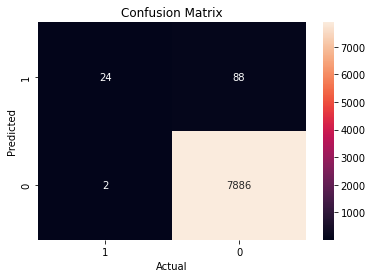

21/08/24 11:33:40 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 949009 ms exceeds timeout 120000 ms
21/08/24 11:33:41 WARN SparkContext: Killing executors is not supported by current scheduler.


In [16]:
conf_matrix = confusion_matrix(true, preds).T
ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title("Confusion Matrix")